# Generation of artifical sequence data based on Categorical Mixture Models

This notebook is an example of how to generate artifical sequences for the HLA-A gene using our approach based on categorical mixture models.

## Section 1: Setup

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
from gentype import AlleleMM, write_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

Set up Classes:

In [2]:
Database_Name = "Gentype_HLA_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Setting the paramaters for our selected allele: HLA-A. For options for ref_name and population_name you can also take a look at the database after fetching.

In [3]:
region_start = 29941260
region_end = 29945884
ref_name = "6" # generally the name of the chromosome
population_name = "ALL"
project_name = "1000GENOMES:phase_3"
allele_args = {'start' : region_start, 'end' : region_end, 'reference_name' : ref_name, 'population' : population_name, 'project' : project_name}

We use store magic to store the values of costly computations (data fetching, model training), so they only have to be done once.

Initialize storable data:

In [4]:
fetched = False
inference_matrix = None
models = None

Restore stored data (remove # to recompute instead of restore respective data):

In [4]:
#%store -d fetched # if you want to refetch the data, uncomment this line
#%store -d inference_matrix # if you want to recompute the inference_matrix, uncomment this line
#%store -d models # if you want to recompute the models, uncomment this line
%store -r

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This only needs to be done once but might take a while.

In [5]:
if not fetched:
    data_manager.fetch_all(region_start, region_end, ref_name, report_progress = True)
fetched = True
%store fetched

Stored 'fetched' (bool)


The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. 

Each row in the matrix represents the variants present in each individual as a bitvector.

In [6]:
if inference_matrix is None:
    inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(**allele_args)
%store inference_matrix 
%store individual_map 
%store variation_map
inference_matrix.shape

Stored 'inference_matrix' (ndarray)
Stored 'individual_map' (dict)
Stored 'variation_map' (dict)


(5008, 438)

Mean number of variations per allele, for HLA-A as expected high.

In [8]:
inference_matrix.sum(axis=1).mean()

91.09704472843451

## Section 3: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

In [7]:
alphas = [0.1,1,10]
gammas = [0.05, 0.1, 0.5, 1]
reinits = 2
if models is None:
    models = [PiCollapsedNonparametricGibbsSampler() for i in range(len(alphas) * len(gammas) * reinits)]
    i = 0
    for alpha in alphas:
        for gamma in gammas:
            for j in range(reinits):
                models[i].fit(inference_matrix, num_burn_in_steps = 20, num_steps=20, delta = 2, alpha = alpha, gamma = gamma)
                i+=1
%store models

Stored 'models' (list)


Model 0:


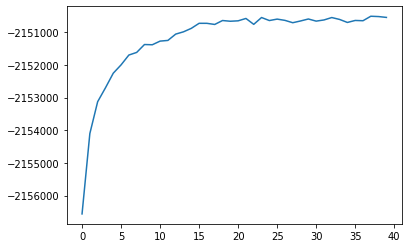

Model 1:


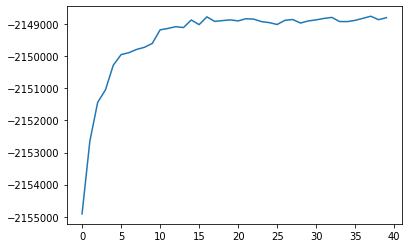

Model 2:


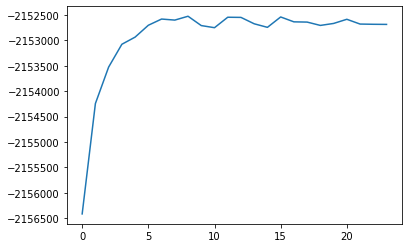

Model 3:


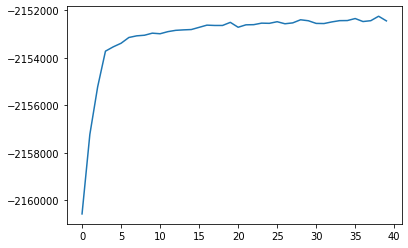

Model 4:


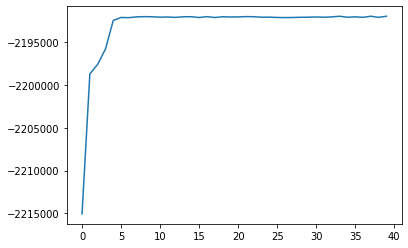

Model 5:


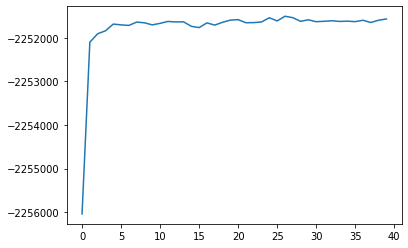

Model 6:


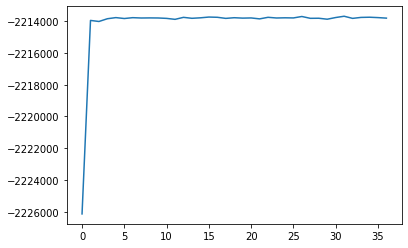

Model 7:


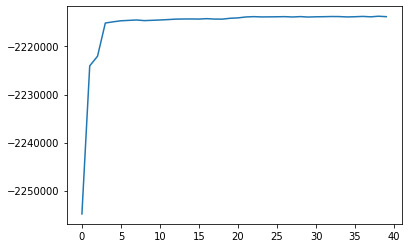

Model 8:


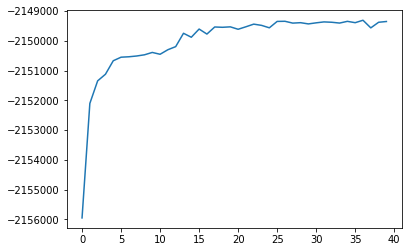

Model 9:


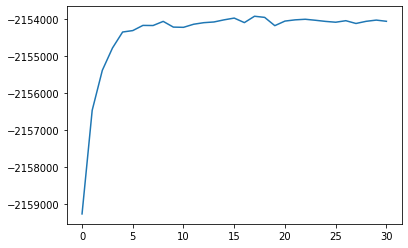

Model 10:


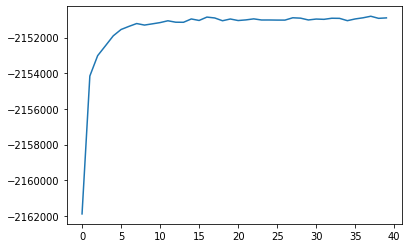

Model 11:


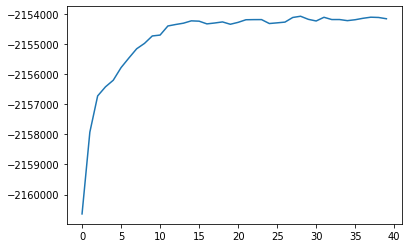

Model 12:


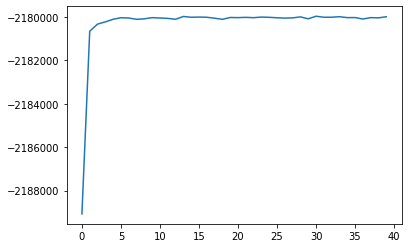

Model 13:


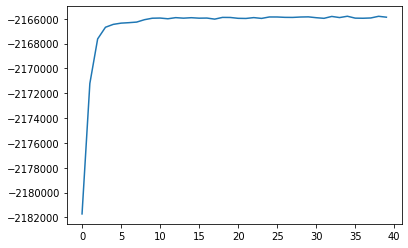

Model 14:


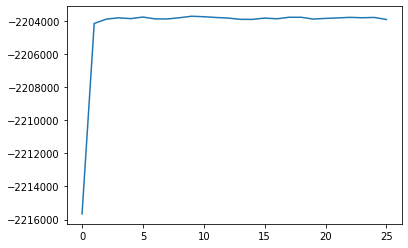

Model 15:


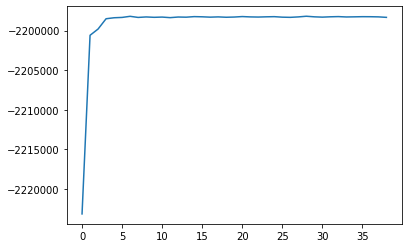

Model 16:


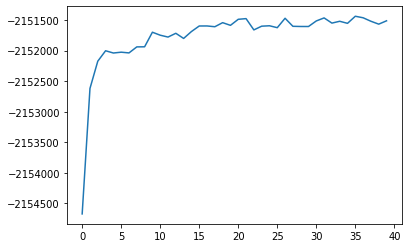

Model 17:


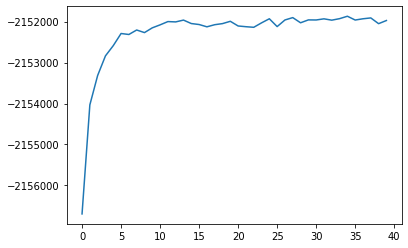

Model 18:


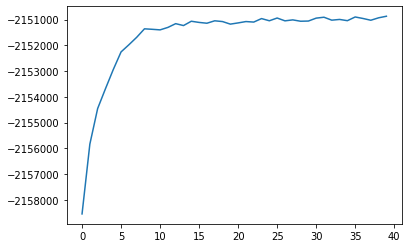

Model 19:


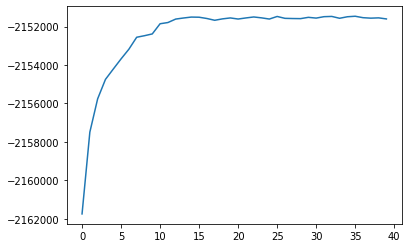

Model 20:


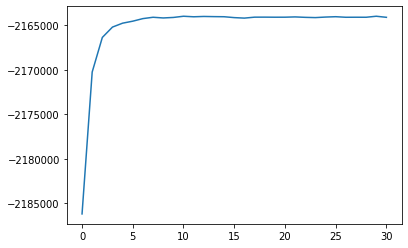

Model 21:


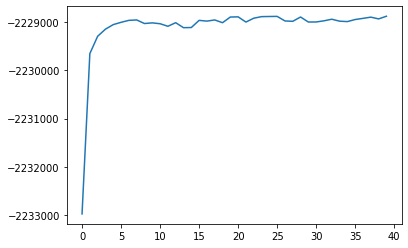

Model 22:


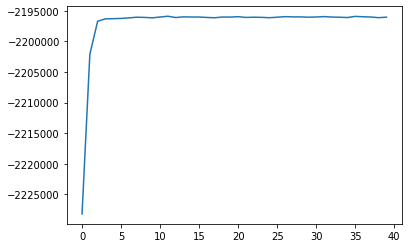

Model 23:


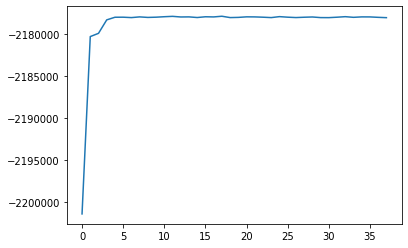

In [12]:
for i, model in enumerate(models):
    print("Model {}:".format(i))
    plt.clf()
    plt.plot(models[i].ll_list)
    plt.show()

May pre select models e.g. according to Aitikens Information Criterion (AIC).

In [8]:
def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood
values = list(map(lambda x: AIC(x), models))
AIC = sorted(zip(values, range(len(values)), list(map(lambda x: x.K_seen, models))), key = lambda x: x[0])
for a in AIC:
    print("AIC: {} Model: {} Cluster {}".format(a[0], a[1], a[2]))

AIC: 4328486.229357244 Model: 11 Cluster 23
AIC: 4328949.562726111 Model: 10 Cluster 31
AIC: 4330648.6948902095 Model: 18 Cluster 33
AIC: 4331238.657762741 Model: 19 Cluster 32
AIC: 4331651.937395125 Model: 2 Cluster 30
AIC: 4332872.455977219 Model: 8 Cluster 39
AIC: 4333506.257826108 Model: 0 Cluster 37
AIC: 4333522.30732656 Model: 1 Cluster 41
AIC: 4333808.995380395 Model: 3 Cluster 33
AIC: 4336312.772248748 Model: 16 Cluster 38
AIC: 4338986.746076773 Model: 17 Cluster 40
AIC: 4339644.955593712 Model: 9 Cluster 36
AIC: 4340444.940952945 Model: 20 Cluster 14
AIC: 4343133.130689506 Model: 13 Cluster 13
AIC: 4365752.202653754 Model: 23 Cluster 11
AIC: 4368742.285723569 Model: 12 Cluster 10
AIC: 4392656.561852405 Model: 4 Cluster 10
AIC: 4400837.250961548 Model: 22 Cluster 10
AIC: 4403644.520742521 Model: 15 Cluster 8
AIC: 4414864.955347032 Model: 14 Cluster 8
AIC: 4433738.8519417085 Model: 7 Cluster 7
AIC: 4433749.812599031 Model: 6 Cluster 7
AIC: 4469150.0687717665 Model: 21 Cluster 13

In [11]:
best_idx = values.index(min(values))
print("Chose model {}.".format(best_idx))

Chose model 11.


In [10]:
# may set manually
#best_idx = 0

## Section 4: Model analysis

In this section we explore our model a little bit.

In [12]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()

array([0.34239843, 0.53971578])

=> Over 50% of the variation can be explained by the first two principle components.

In [90]:
inds = [0]*len(inference_matrix)
for ind, pos in individual_map.items():
    inds[2*pos] = ind
    inds[2*pos+1] = ind
# Ploting for superpopulations
populations = ["AFR", "AMR", "EAS", "EUR", "SAS"]
ind_map = data_manager.generate_individual_population_map()
population_index = []
for ind in inds:
    for pop in ind_map[ind]:
        if pop in populations:
            population_index.append(populations.index(pop))
pops = np.array(population_index)

Here we plot the PCA for all individuals colored first by superpopulation, then by cluster assignment

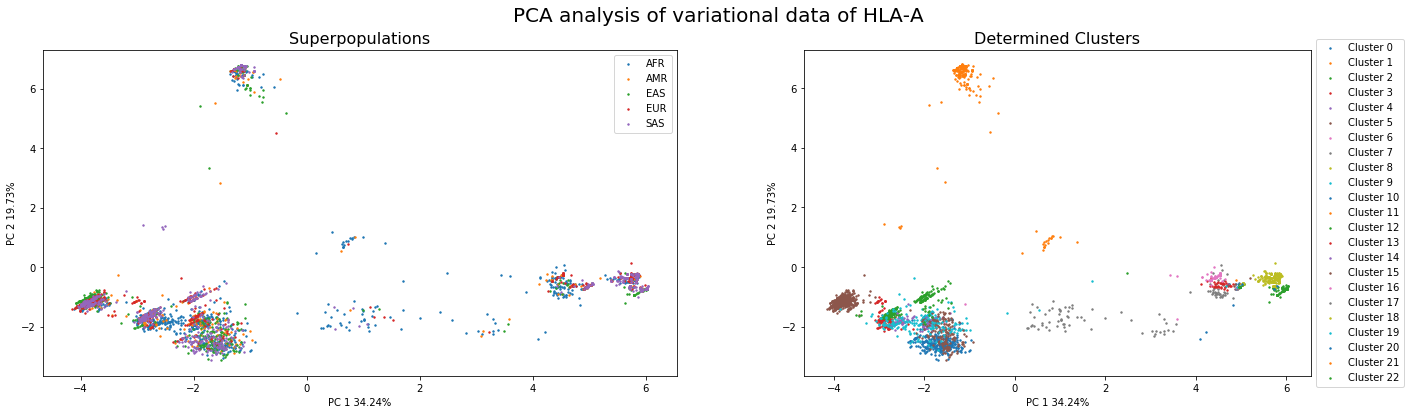

In [91]:
fig, ax = plt.subplots(1,2,figsize = (25,6))
variance = pca.explained_variance_ratio_
fig.suptitle("PCA analysis of variational data of HLA-A", fontsize=20)


for i in range(models[best_idx].K_seen):
    ax[0].set_title("Superpopulations", fontsize=16)
    ax[0].scatter(principalComponents[pops == i,0], principalComponents[pops == i,1], s=2)
    ax[0].set_xlabel("PC 1 " + str(round(variance[0]*100, 2)) + "%")
    ax[0].set_ylabel("PC 2 " + str(round(variance[1]*100, 2)) + "%")
ax[0].legend(populations)
for i in range(models[best_idx].K_seen):
    ax[1].set_title("Determined Clusters", fontsize=16)
    ax[1].scatter(principalComponents[models[best_idx].Z == i,0], principalComponents[models[best_idx].Z == i,1], s=2)
    ax[1].set_xlabel("PC 1 " + str(round(variance[0]*100, 2)) + "%")
    ax[1].set_ylabel("PC 2 " + str(round(variance[1]*100, 2)) + "%")

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax[1].legend(["Cluster " + str(i) for i in range(models[best_idx].K_seen)], loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("pca_HLA.pdf")

In [19]:
pops_per_cluster = np.array([np.histogram(pops[models[best_idx].Z == i], bins=5)[0] for i in range(models[best_idx].K_seen)])
#pops_per_cluster = pops_per_cluster / pops_per_cluster.sum(axis=0)
df = pd.DataFrame(dict(zip(["AFR", "AMR", "EAS", "EUR", "SAS"], pops_per_cluster.T)))
df.index = ["Cluster " + str(i) for i in range(len(models[best_idx].theta))]

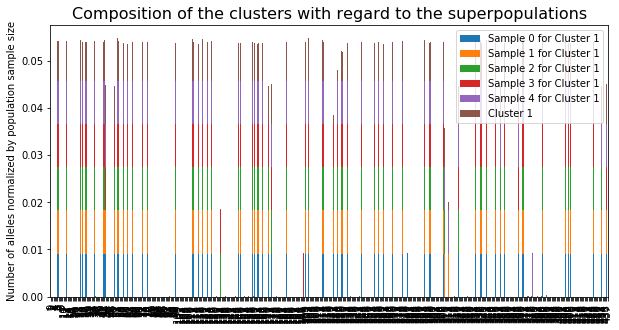

In [92]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Composition of the clusters with regard to the superpopulations", fontsize=16)
ax.set_ylabel("Number of alleles normalized by population sample size")
df.plot(kind="bar", stacked=True, ax=ax)
fig.savefig("pop_per_cluster.pdf")


In the following we plot the probability for each variant for each of the clusters. We can see that each cluster has a distinct pattern of variants.

In [21]:
df2 = pd.DataFrame(dict(zip(["Cluster " + str(i) for i in range(len(models[best_idx].theta))], list(models[best_idx].theta))))
df2.head(3)

Cluster 0     Cluster 1  Cluster 2     Cluster 3     Cluster 4  \
0  2.955727e-03  2.516052e-05   0.000018  4.634426e-09  1.388341e-11   
1  1.047690e-04  1.206995e-05   0.000139  9.207015e-03  2.322299e-10   
2  1.577502e-10  2.530639e-10   0.017747  2.591448e-07  9.118534e-17   

      Cluster 5     Cluster 6     Cluster 7     Cluster 8     Cluster 9  ...  \
0  9.137225e-03  4.301069e-03  1.138611e-04  8.630215e-14  5.761869e-06  ...   
1  8.791652e-03  6.315361e-06  1.937072e-04  3.052349e-07  2.106617e-05  ...   
2  9.702389e-09  1.968682e-15  8.091162e-11  1.685228e-02  1.603324e-08  ...   

     Cluster 13    Cluster 14    Cluster 15    Cluster 16    Cluster 17  \
0  4.370799e-04  2.963240e-04  3.068263e-06  4.991969e-08  8.028607e-04   
1  3.896414e-10  8.920438e-03  4.210351e-11  1.583326e-06  9.284911e-04   
2  3.412104e-04  1.036486e-07  1.224413e-06  2.391701e-21  7.873504e-08   

   Cluster 18  Cluster 19    Cluster 20    Cluster 21    Cluster 22  
0    0.000004    0.007056  7.803395e-07  5.432756e-04  9.658138e-05  
1    0.000635    0.007288  2.038961e-08  3.579855e-13  2.566592e-05  
2    0.016559    0.000066  1.198072e-02  7.330466e-11  1.254821e-09  

[3 rows x 23 columns]

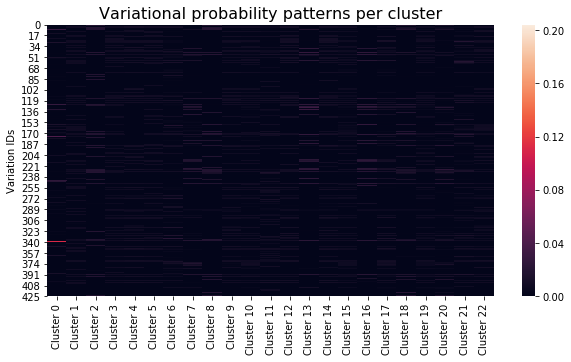

In [22]:
id_map = dict(map(lambda x: reversed(x),variation_map.items()))
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Variational probability patterns per cluster", fontsize=16)
ax = sns.heatmap(df2)
ax.set_ylabel("Variation IDs")
fig.savefig("HLA_patterns.pdf")

## Section 6: Generative Validation

In [13]:
from gentype import AlleleMM, get_distances

In [14]:
split_point = int(len(inference_matrix) - len(inference_matrix)/3)
# if we want to keep using our mapping we need to use the first half for training
inference_matrix_training = inference_matrix[:split_point]
inference_matrix_test = inference_matrix[split_point:]

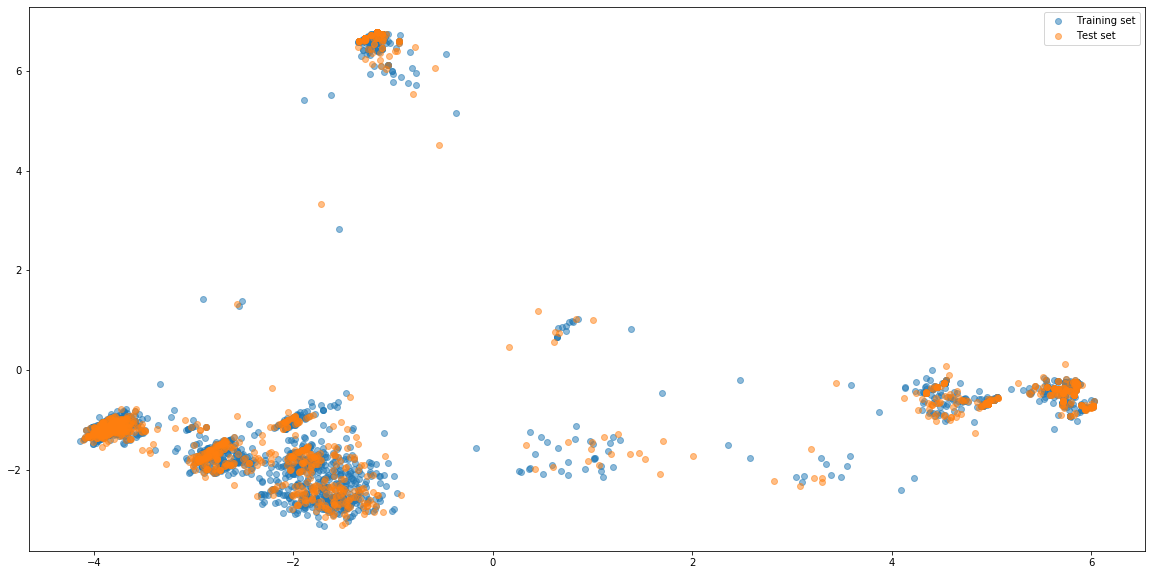

In [17]:
fig, ax = plt.subplots(figsize = (20,10))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()
ax.plot(principalComponents[:split_point,0], principalComponents[:split_point,1], "o", alpha=0.5)
ax.plot(principalComponents[split_point:,0], principalComponents[split_point:,1], "o", alpha=0.5)
ax.legend(["Training set", "Test set"])

In [ ]:
# We will test a low and high cluster number model

In [18]:
eval_models = [PiCollapsedNonparametricGibbsSampler() for i in range(2)]
eval_models[0].fit(inference_matrix_training, num_burn_in_steps = 20, num_steps=20, delta = 2, alpha = 0.1, gamma = 0.1)

Iteration: 1; Current clusters: 36; Likelihood: -1447007.829
Iteration: 2; Current clusters: 30; Likelihood: -1444157.437
Iteration: 3; Current clusters: 29; Likelihood: -1443289.591
Iteration: 4; Current clusters: 28; Likelihood: -1442704.782
Iteration: 5; Current clusters: 27; Likelihood: -1442631.997
Iteration: 6; Current clusters: 27; Likelihood: -1442540.458
Iteration: 7; Current clusters: 27; Likelihood: -1442401.435
Iteration: 8; Current clusters: 27; Likelihood: -1442261.491
Iteration: 9; Current clusters: 27; Likelihood: -1442061.654
Iteration: 10; Current clusters: 27; Likelihood: -1442042.574
Iteration: 11; Current clusters: 26; Likelihood: -1441776.922
Iteration: 12; Current clusters: 26; Likelihood: -1441708.479
Iteration: 13; Current clusters: 26; Likelihood: -1441744.915
Iteration: 14; Current clusters: 26; Likelihood: -1441690.978
Iteration: 15; Current clusters: 26; Likelihood: -1441612.354
Iteration: 16; Current clusters: 26; Likelihood: -1441663.092
Iteration: 17; Cu

In [21]:
eval_models[1].fit(inference_matrix_training, num_burn_in_steps = 20, num_steps=20, delta = 2, alpha = 10, gamma = 0.5)

Iteration: 1; Current clusters: 13; Likelihood: -1474252.872
Iteration: 2; Current clusters: 13; Likelihood: -1459526.063
Iteration: 3; Current clusters: 12; Likelihood: -1458218.391
Iteration: 4; Current clusters: 13; Likelihood: -1457578.675
Iteration: 5; Current clusters: 12; Likelihood: -1457373.974
Iteration: 6; Current clusters: 14; Likelihood: -1457164.819
Iteration: 7; Current clusters: 13; Likelihood: -1456705.970
Iteration: 8; Current clusters: 12; Likelihood: -1455341.999
Iteration: 9; Current clusters: 10; Likelihood: -1454746.945
Iteration: 10; Current clusters: 11; Likelihood: -1454441.125
Iteration: 11; Current clusters: 12; Likelihood: -1454130.126
Iteration: 12; Current clusters: 10; Likelihood: -1454016.367
Iteration: 13; Current clusters: 11; Likelihood: -1453961.876
Iteration: 14; Current clusters: 12; Likelihood: -1454026.185
Iteration: 15; Current clusters: 11; Likelihood: -1453992.382
Iteration: 16; Current clusters: 11; Likelihood: -1453980.651
Iteration: 17; Cu

In [69]:
def sample(number_of_samples, eval_model):
    variant_ranges = data_manager.get_variation_range(**allele_args)
    mm = AlleleMM(eval_model.Z, eval_model.theta, inference_matrix_training, variant_ranges, variation_map)
    number_of_samples = number_of_samples
    samples = []
    clusters = []
    descriptions = []
    for i in range(number_of_samples):
        characteristic_vector = np.zeros(len(eval_model.theta[0]))
        sample, cluster = mm.sample_variations(return_cluster = True)
        characteristic_vector[sample] = 1
        samples.append(characteristic_vector)
        clusters.append(cluster)

    return samples, clusters, descriptions

In [28]:
null_model = inference_matrix_training.sum(axis=0)
null_model /= inference_matrix_training.sum()

draws = inference_matrix_training.sum(axis=1)
unique_elements, counts_elements = np.unique(draws, return_counts=True)
counts_elements = counts_elements / counts_elements.sum()

def null_model_sample(number_of_samples, vec_size = 438):
    null_samples = []
    for i in range(number_of_samples):
        s = np.zeros(vec_size)
        variants =  np.random.choice(range(vec_size), p= null_model, size = int(np.random.choice(unique_elements, p =counts_elements)), replace=False)
        for var in variants:
            s[var] = 1
        null_samples.append(s)
    return null_samples


In [67]:
def KL_div(p, q):
    return np.nan_to_num([p[i] * np.log(p[i]/q[i]) for i in range(len(p))]).sum()

In [70]:
SAMPLE_SIZE = 200
repeats = 10
samples1 = [sample(SAMPLE_SIZE, eval_models[0]) for i in range(repeats)]

In [71]:
samples2 = [sample(SAMPLE_SIZE, eval_models[1]) for i in range(repeats)]

In [72]:
samples_null = [null_model_sample(SAMPLE_SIZE) for i in range(repeats)]

In [54]:
def evaluate(samples):
    assigned_distance, distributions, assignments = get_distances(samples, inference_matrix_test, return_assignments = True)

    sum_distances = 0
    for sample in samples:
        sum_distances += assigned_distance[tuple(sample)]
    avg_distances = sum_distances/len(samples)

    distribution_difference = 0
    test_probabilites = []
    generated_probabilites = []
    test_set = [tuple(individual) for individual in inference_matrix_test]
    for individual in set(test_set):
        test_quota, generated_quota = distributions[individual]
        test_probabilites.append(test_quota)
        generated_probabilites.append(generated_quota)
        distribution_difference += np.absolute(test_quota - generated_quota)

    return avg_distances, distribution_difference, KL_div(generated_probabilites, test_probabilites)

In [73]:
ham_dists = []
kl_dists = []
for sample in samples1:
    print("Started next")
    eval = evaluate(sample[0])
    ham_dists.append(eval[0])
    kl_dists.append(eval[2])

Started next
/home/manu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/manu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
Started next
Started next
Started next
Started next
Started next
Started next
Started next
Started next
Started next


In [74]:
print("Mean Ham Dist:" + str(round(np.mean(ham_dists), 2)))
print("Std Ham Dist" + str(round(np.std(ham_dists), 2)))
print("Mean KL:" + str(round(np.mean(kl_dists), 2)))
print("Std KL:" + str(round(np.std(kl_dists), 2)))

Mean Ham Dist:10.33
Std Ham Dist0.61
Mean KL:1.62
Std KL:0.07


In [75]:
ham_dists = []
kl_dists = []
for sample in samples2:
    print("Started next")
    eval = evaluate(sample[0][:100])
    ham_dists.append(eval[0])
    kl_dists.append(eval[2])

Started next
/home/manu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/manu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
Started next
Started next
Started next
Started next
Started next
Started next
Started next
Started next
Started next


In [76]:
print("Mean Ham Dist:" + str(round(np.mean(ham_dists), 2)))
print("Std Ham Dist" + str(round(np.std(ham_dists), 2)))
print("Mean KL:" + str(round(np.mean(kl_dists), 2)))
print("Std KL:" + str(round(np.std(kl_dists), 2)))

Mean Ham Dist:16.87
Std Ham Dist1.31
Mean KL:2.11
Std KL:0.08


In [77]:
ham_dists = []
kl_dists = []
for sample in samples_null:
    print("Started next")
    eval = evaluate(sample[:100])
    ham_dists.append(eval[0])
    kl_dists.append(eval[2])

Started next
/home/manu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/manu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
Started next
Started next
Started next
Started next
Started next
Started next
Started next
Started next
Started next


In [78]:
print("Mean Ham Dist:" + str(round(np.mean(ham_dists), 2)))
print("Std Ham Dist" + str(round(np.std(ham_dists), 2)))
print("Mean KL:" + str(round(np.mean(kl_dists), 2)))
print("Std KL:" + str(round(np.std(kl_dists), 2)))

Mean Ham Dist:63.66
Std Ham Dist1.84
Mean KL:2.84
Std KL:0.07


For comparission we will compare against a null model, where we assume a single Categroical distribution as generative model. We obtain:

## Section 6: Sequence Generation

The following builds a sequence generator from the parameters which were determined during model training.

In [79]:
variant_ranges = data_manager.get_variation_range(**allele_args)
mm = AlleleMM(models[best_idx].Z, models[best_idx].theta, inference_matrix, variant_ranges, variation_map)

We can then sample a set of indices which can be mapped to variant ids.

In [80]:
sample = mm.sample_variations()

We can compare the samples to the respective cluster. Here the choice of cluster is equally distributed. In the sampling without specified cluster it is determined based on infered paramters, i.e. in reality some clusters might be much more rare than it may seem here.

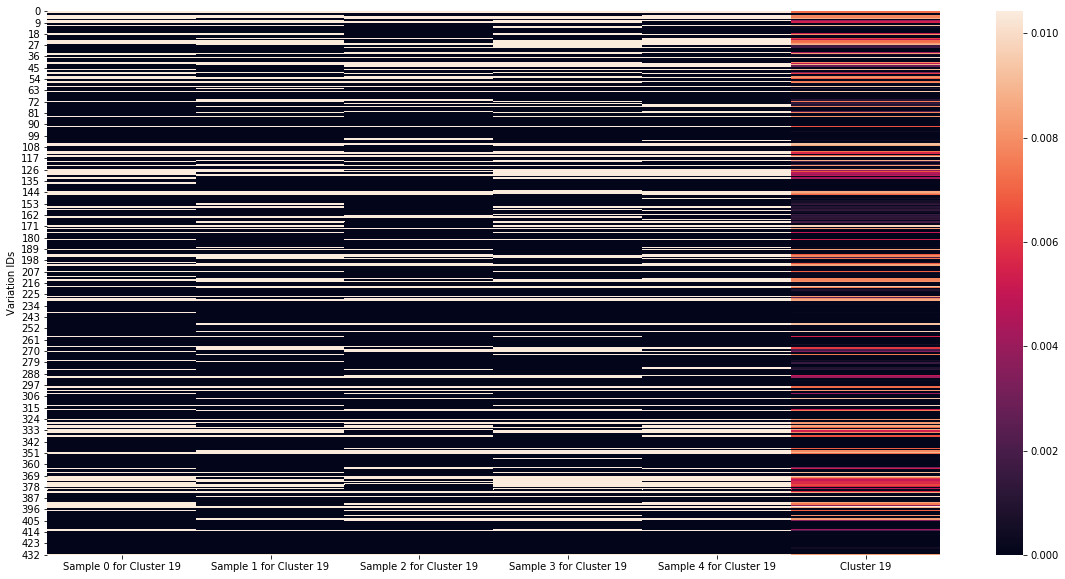

In [94]:
number_of_samples = 5
samples = []
descriptions = []
k = np.random.choice(range(int(max(models[best_idx].Z))))
theta = models[best_idx].theta[k]
indicator_value = theta.max()
for i in range(number_of_samples):
    characteristic_vector = np.zeros(len(theta))
    characteristic_vector[mm.sample_variations(k)] = indicator_value
    samples.append(characteristic_vector)
    descriptions.append("Sample {} for Cluster {}".format(i, k))
samples.append(theta)
descriptions.append("Cluster {}".format(k))
df = pd.DataFrame(dict(zip(descriptions, samples)))
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)
ax.set_ylabel("Variation IDs")
fig.savefig("samples_example.pdf")
    

In order to now actually generate a sequence we first need to convert our bitvector back to variants.

In [85]:
invert_variation_map = {}
for key in variation_map:
    invert_variation_map[variation_map[key]] = key
alternates_map = data_manager.get_variation_alternate(**allele_args)

sample = mm.sample_variations()
selected_variants = [alternates_map[invert_variation_map[index]] for index in sample]
selected_variants.sort(key = lambda x: x[1])
#selected_variants

And then insert them into the reference sequence.

In [86]:
seq_data = data_manager.fetch_region(region_start, region_end, ref_name)
seq = seq_data['seq']
header = seq_data['id']
offset = region_start # to compute variant coordinates relative to region start
sequence_parts = []
start = 0
offset_start = 0
for variant in selected_variants:
    offset_start = variant[1] - offset
    offset_end = variant[2] - offset
    sequence_parts.append(seq[start: offset_start])
    sequence_parts.append(np.random.choice(variant[0]))
    start = offset_end
sequence_parts.append(seq[start:])
generated_sequence = "".join(sequence_parts)
#generated_sequence

We can also write the created sequences into a fasta file.

In [87]:
number_of_sequences = 5
sequences = []
headers = []
for i in range(number_of_sequences):
    sample = mm.sample_variations()
    selected_variants = [alternates_map[invert_variation_map[index]] for index in sample]
    selected_variants.sort(key = lambda x: x[1])
    sequence_parts = []
    start = 0
    offset_start = 0
    for variant in selected_variants:
        offset_start = variant[1] - offset
        offset_end = variant[2] - offset
        sequence_parts.append(seq[start: offset_start])
        sequence_parts.append(np.random.choice(variant[0]))
        start = offset_end
    sequence_parts.append(seq[start:])
    generated_sequence = "".join(sequence_parts)
    sequences.append(generated_sequence)
    headers.append(">{} - artifical variation {}".format(header, i))
write_sequences("Generated Variations.fasta", headers, sequences)

For comparison we also write the reference sequence to a seperate fasta file.

In [88]:
write_sequences("Reference Sequence.fasta", [">{}".format(header)], [seq])